<a href="https://colab.research.google.com/github/shantanupatil23/Angela-Yu-Web-Bootcamp-2020/blob/master/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, precision_recall_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
from google.colab import drive

In [2]:
# Load preprocessed data
drive.mount('/content/drive', force_remount=True)
file_dir = "/content/drive/My Drive/DS/Submission/dataset"
processed_file_path = os.path.join(file_dir, 'processed_data.csv')
data = pd.read_csv(processed_file_path)
print("Data loaded for modeling.")

Mounted at /content/drive
Data loaded for modeling.


In [3]:
# Threshold research and justification
Nbrighton = 114479  # Example value, replaced with actual data #https://www.brighton-hove.gov.uk/sites/default/files/migrated/subject/inline/downloads/citystats/4_Housing.pdf
Npilot = 0.10 * Nbrighton  # 10% of Brighton houses
E = 0.31  # Average hourly consumption per house in kWh, example value #https://www.uswitch.com/gas-electricity/guides/average-gas-and-electricity-bills-in-the-uk/ #In Brighton, UK, the average electricity consumption per household is in line with the broader UK averages. A typical household, which is generally defined as having 2-3 occupants and a home size of 2-3 bedrooms, consumes approximately 2,700 kWh of electricity annually. This equates to around 7.4 kWh per day or approximately 0.31 kWh per hour on average. These figures can vary depending on the size of the home and the number of occupants. For instance, a smaller household in a 1-2 bedroom flat might use less electricity, around 1,800 kWh per year, while a larger household in a 4+ bedroom home could consume up to 4,100 kWh annually.
K = 10  # Chosen multiplier, could be between 3 and 10

threshold = Npilot * E * K + Nbrighton * E
print(f"Calculated surplus threshold: {threshold} kWh")


Calculated surplus threshold: 70976.98000000001 kWh


In [4]:
def calculate_air_density(temp_celsius, humidity_percent, pressure_hpa):
    """
    Calculate air density given temperature, humidity, and pressure.

    Parameters:
    temp_celsius (float): Temperature in degrees Celsius
    humidity_percent (float): Relative humidity in percent
    pressure_hpa (float): Pressure in hectopascals (hPa)

    Returns:
    float: Air density in kg/m³
    """
    # Convert temperature to Kelvin
    temp_kelvin = temp_celsius + 273.15

    # Convert pressure to Pascals
    pressure_pa = pressure_hpa * 100

    # Calculate saturation vapor pressure using Tetens formula
    p_sat = 611.2 * np.exp((17.67 * temp_celsius) / (temp_celsius + 243.5))

    # Calculate partial pressure of water vapor
    p_v = (humidity_percent / 100) * p_sat

    # Calculate partial pressure of dry air
    p_d = pressure_pa - p_v

    # Constants for gas constants
    R_d = 287.05  # Specific gas constant for dry air in J/(kg·K)
    R_v = 461.495  # Specific gas constant for water vapor in J/(kg·K)

    # Calculate air density
    air_density = (p_d / (R_d * temp_kelvin)) + (p_v / (R_v * temp_kelvin))

    return air_density


In [5]:
# Wind energy calculation
# air_density = 1.225  # kg/m³
data['air_density'] = data.apply(lambda row: calculate_air_density(row['temp'], row['humidity'], row['sealevelpressure']), axis=1)
blade_length = 25  # meters
swept_area = np.pi * blade_length**2  # m²
efficiency = E # Average hourly consumption per house in kWh
number_of_turbines = 50

# Calculate wind power in watts (W)
data['wind_power_watts'] = 0.5 * data['air_density'] * swept_area * (data['windspeed'] ** 3) * efficiency

# Convert power to energy (Wh) assuming each reading represents an hourly average
data['wind_energy_wh'] = data['wind_power_watts'] / 1000  # convert from W to kWh

# Total energy produced by 50 turbines
data['total_wind_energy_kwh'] = data['wind_energy_wh'] * number_of_turbines
avg_total_wind_energy_kwh = data['total_wind_energy_kwh'].sum() / len(data['total_wind_energy_kwh'])
print("Wind energy calculation completed.")
print(f"Average Total Wind Energy: {avg_total_wind_energy_kwh} kWh")

Wind energy calculation completed.
Average Total Wind Energy: 157985.37106712902 kWh


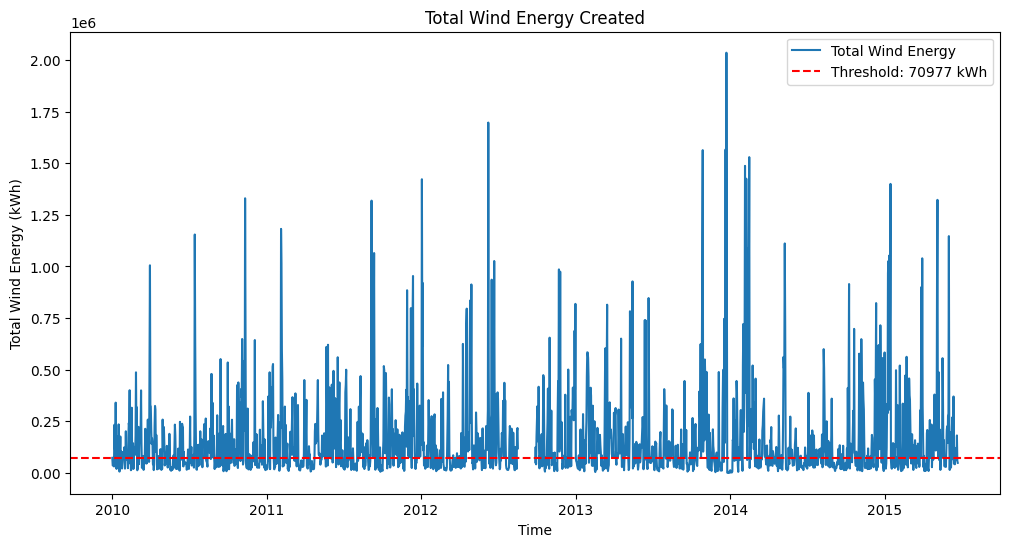

In [6]:
# Ensure 'datetime' is in datetime format and set it as the index
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

# Resample the data to smooth out the graph
daily_data = data['total_wind_energy_kwh'].resample('D').mean()

# Visualization - Wind Energy
plt.figure(figsize=(12, 6))
plt.plot(daily_data.index, daily_data, label='Total Wind Energy')

# Add horizontal line for threshold
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {round(threshold)} kWh')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xlabel('Time')
plt.ylabel('Total Wind Energy (kWh)')
plt.title('Total Wind Energy Created')
plt.legend()
plt.show()

In [7]:
# Define features and target
X = data[['temp', 'humidity', 'solarradiation', 'uvindex', 'windspeed']]
y = data['total_wind_energy_kwh']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train-test split completed.")

Train-test split completed.


In [8]:
# Model training and evaluation
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_rmse = mean_squared_error(y_test, y_pred) ** 0.5
    print(f'{name} Test RMSE: {test_rmse}')
    print(f'{name} Accuracy Percentage: {round(100-((test_rmse/avg_total_wind_energy_kwh)*100), 2)}%')

RandomForest Test RMSE: 4041.874680986084
RandomForest Accuracy Percentage: 97.44%
GradientBoosting Test RMSE: 4370.601348356688
GradientBoosting Accuracy Percentage: 97.23%


In [9]:
# Voting Regressor (Ensemble Model)
voting_reg = VotingRegressor(estimators=[('rf', models['RandomForest']), ('gb', models['GradientBoosting'])])
voting_reg.fit(X_train, y_train)
y_pred_ensemble = voting_reg.predict(X_test)
test_rmse_ensemble = mean_squared_error(y_test, y_pred_ensemble) ** 0.5
print(f'Ensemble Test RMSE: {test_rmse_ensemble}')
print(f'Ensemble Accuracy Percentage: {round(100-((test_rmse_ensemble/avg_total_wind_energy_kwh)*100), 2)}%')

Ensemble Test RMSE: 3844.3025581942848
Ensemble Accuracy Percentage: 97.57%


In [10]:
'''
old code with warnings

# Enhanced feature engineering with more lagged features
for lag in range(1, 49):  # Extending up to 48 hours
    data[f'wind_speed_lag_{lag}'] = data['windspeed'].shift(lag)
    data[f'temp_lag_{lag}'] = data['temp'].shift(lag)
    data[f'humidity_lag_{lag}'] = data['humidity'].shift(lag)
    data[f'solarradiation_lag_{lag}'] = data['solarradiation'].shift(lag)

# Add interaction features
data['temp_humidity_interaction'] = data['temp'] * data['humidity']
data['wind_speed_temp_interaction'] = data['windspeed'] * data['temp']

# Drop rows with NaN values created by lagging
data.dropna(inplace=True)
print("Lagged features and interactions added.")
'''


# Create a dictionary to hold lagged features
lagged_features_dict = {}

# Generate lagged features
# Enhance feature engineering with more lagged features
for lag in range(1, 25):  # Extending up to 48 hours, before it was 48
    lagged_features_dict[f'humidity_lag_{lag}'] = data['humidity'].shift(lag)
    lagged_features_dict[f'solarradiation_lag_{lag}'] = data['solarradiation'].shift(lag)

for lag in range(1, 13):  # 12-hour window for windspeed
    lagged_features_dict[f'wind_speed_lag_{lag}'] = data['windspeed'].shift(lag)

for lag in range(1, 16):  # 15-hour window for temperature
    lagged_features_dict[f'temp_lag_{lag}'] = data['temp'].shift(lag)

# Add interaction features to the dictionary
lagged_features_dict['temp_humidity_interaction'] = data['temp'] * data['humidity']
lagged_features_dict['wind_speed_temp_interaction'] = data['windspeed'] * data['temp']

# Convert the dictionary to a DataFrame
lagged_features = pd.DataFrame(lagged_features_dict)

# Concatenate the new features with the original DataFrame
data = pd.concat([data, lagged_features], axis=1)

# Drop rows with NaN values created by lagging
data.dropna(inplace=True)

print("Lagged features and interactions added.")

Lagged features and interactions added.


In [11]:
# Define features and target for the model
X = data[[col for col in data.columns if 'lag' in col]]
y = data['total_wind_energy_kwh'].shift(-24).dropna()  # shift target 24 hours ahead
X = X.iloc[:-24]  # align features with target
print("Features and target redefined for modeling.")

Features and target redefined for modeling.


In [12]:
# Gradient Boosting hyperparameter tuning
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

gb = GradientBoostingRegressor(random_state=42)
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search_gb.fit(X_train, y_train)

best_gb = grid_search_gb.best_estimator_
y_pred_gb = best_gb.predict(X_test)
test_rmse_gb = mean_squared_error(y_test, y_pred_gb) ** 0.5
print(f'Optimized Gradient Boosting Test RMSE: {test_rmse_gb}')
print(f'Optimized Gradient Boosting Test Accuracy Percentage: {round(100-((test_rmse_gb/avg_total_wind_energy_kwh)*100), 2)}%')

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Optimized Gradient Boosting Test RMSE: 3326.240854663167
Optimized Gradient Boosting Test Accuracy Percentage: 97.89%


In [13]:
# Random Forest hyperparameter tuning
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)

best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
test_rmse_rf = mean_squared_error(y_test, y_pred_rf) ** 0.5
print(f'Optimized Random Forest Test RMSE: {test_rmse_rf}')
print(f'Optimized Random Forest Test Accuracy Percentage: {round(100-((test_rmse_rf/avg_total_wind_energy_kwh)*100), 2)}%')

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Optimized Random Forest Test RMSE: 4167.167932168118
Optimized Random Forest Test Accuracy Percentage: 97.36%


In [14]:
# Voting Regressor ensemble with tuned models
voting_reg = VotingRegressor(estimators=[
    ('rf', best_rf),
    ('gb', best_gb)
])
voting_reg.fit(X_train, y_train)
y_pred_ensemble = voting_reg.predict(X_test)
test_rmse_ensemble = mean_squared_error(y_test, y_pred_ensemble) ** 0.5
print(f'Ensemble Test RMSE: {test_rmse_ensemble}')
print(f'Ensemble Test Accuracy Percentage: {round(100-((test_rmse_ensemble/avg_total_wind_energy_kwh)*100), 2)}%')

Ensemble Test RMSE: 3617.1753913703624
Ensemble Test Accuracy Percentage: 97.71%


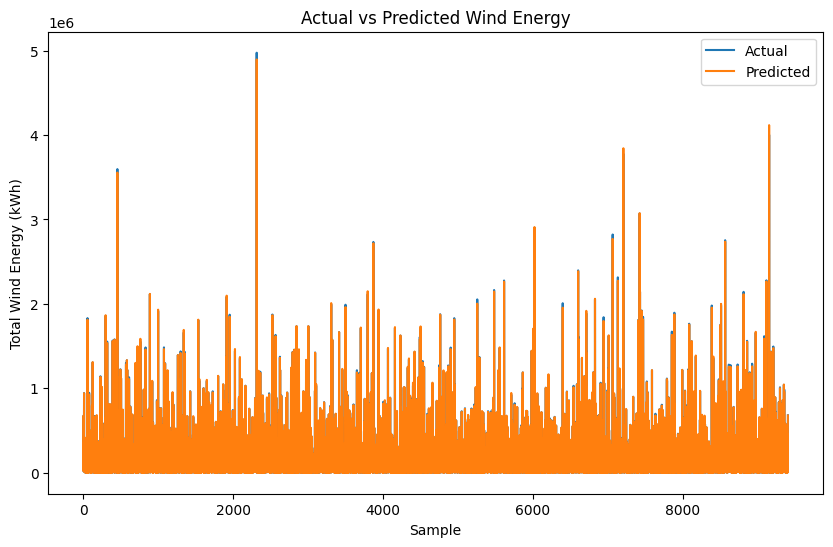

In [15]:
# Visualization - Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_ensemble, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Total Wind Energy (kWh)')
plt.title('Actual vs Predicted Wind Energy')
plt.legend()
plt.show()

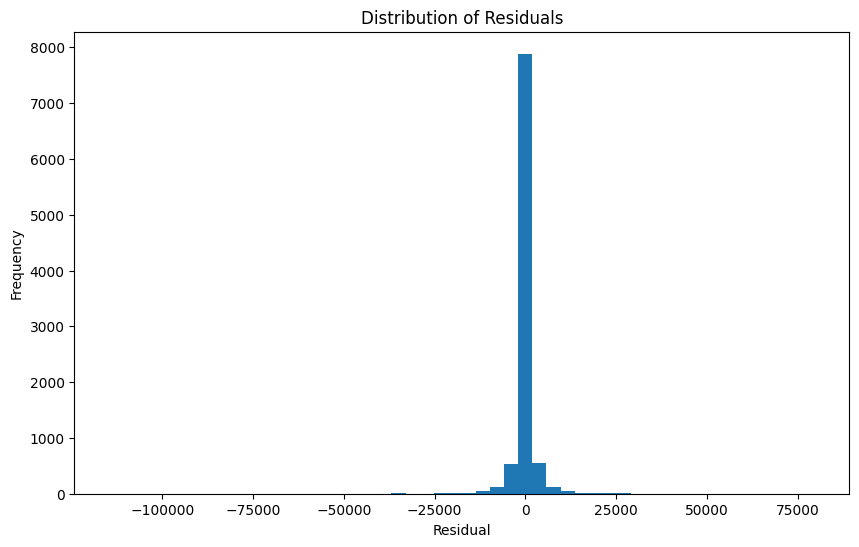

In [16]:
# Plot residuals
residuals = y_test - y_pred_ensemble
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

In [17]:
# Train-test-validation split for classification
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
voting_reg.fit(X_train, y_train)

# Predictions
y_train_pred = voting_reg.predict(X_train)
y_val_pred = voting_reg.predict(X_val)
y_test_pred = voting_reg.predict(X_test)

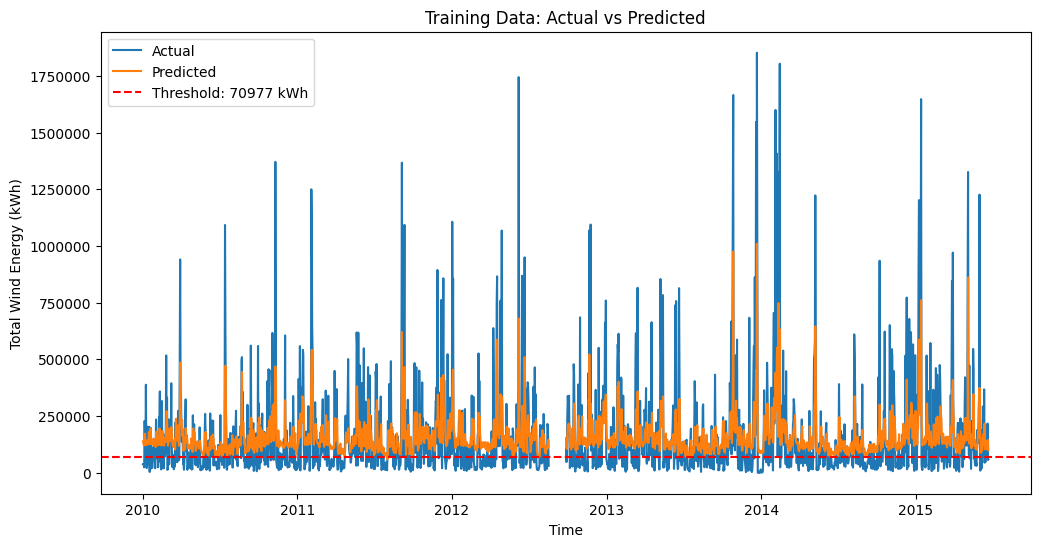

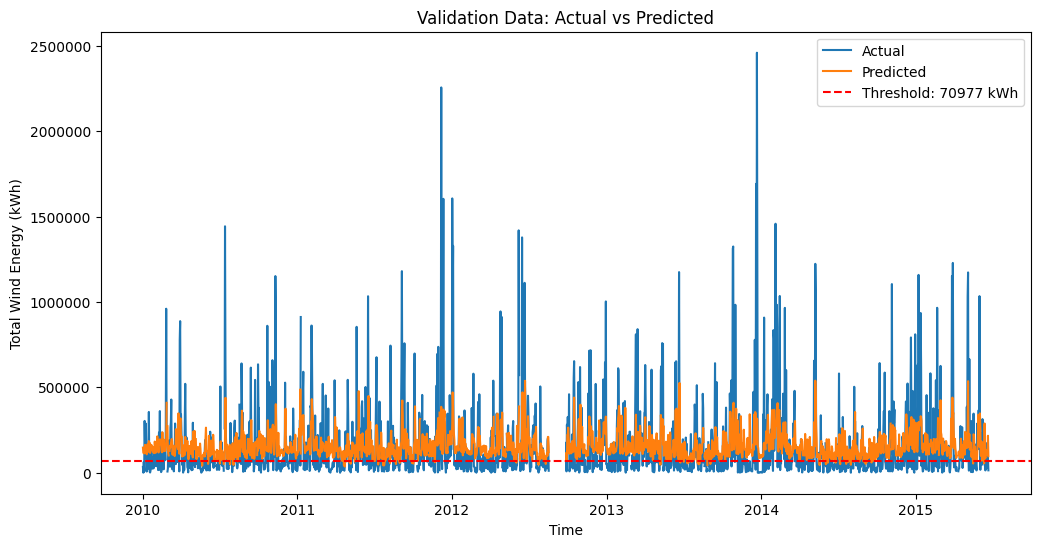

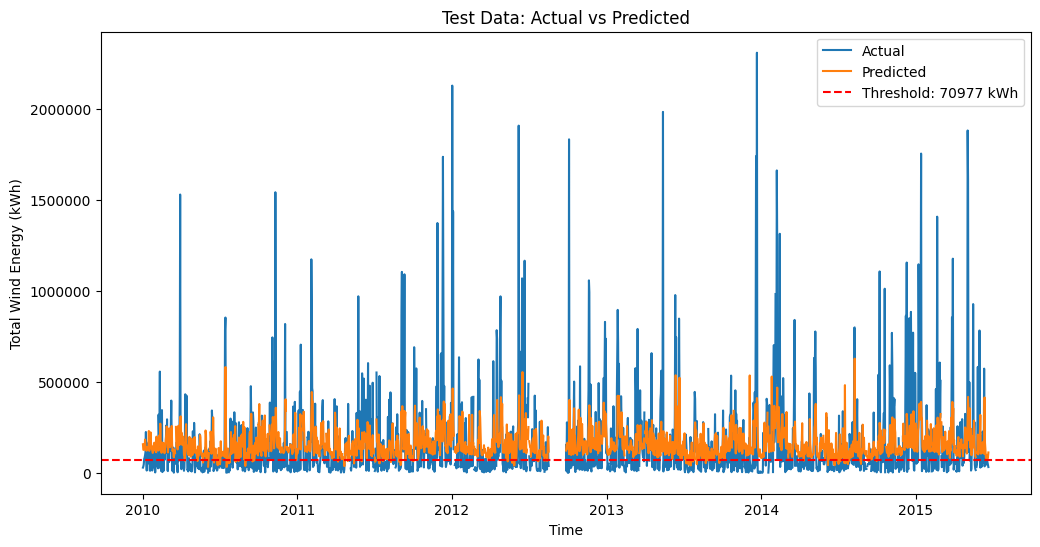

In [18]:
# Plotting function for actual vs predicted
def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(12, 6))

    # Smooth out the data
    y_true_smooth = y_true.resample('D').mean()
    y_pred_smooth = pd.Series(y_pred, index=y_true.index).resample('D').mean()

    plt.plot(y_true_smooth.index, y_true_smooth, label='Actual')
    plt.plot(y_true_smooth.index, y_pred_smooth, label='Predicted')

    # Add horizontal line for threshold
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {round(threshold)} kWh')

    plt.gca().xaxis.set_major_locator(mdates.YearLocator())

    plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
    plt.gca().yaxis.get_major_formatter().set_useOffset(False)
    plt.gca().yaxis.get_major_formatter().set_scientific(False)

    plt.xlabel('Time')
    plt.ylabel('Total Wind Energy (kWh)')
    plt.title(title)
    plt.legend()
    plt.show()

# Plot actual vs predicted for different sets
plot_actual_vs_predicted(y_train, y_train_pred, 'Training Data: Actual vs Predicted')
plot_actual_vs_predicted(y_val, y_val_pred, 'Validation Data: Actual vs Predicted')
plot_actual_vs_predicted(y_test, y_test_pred, 'Test Data: Actual vs Predicted')

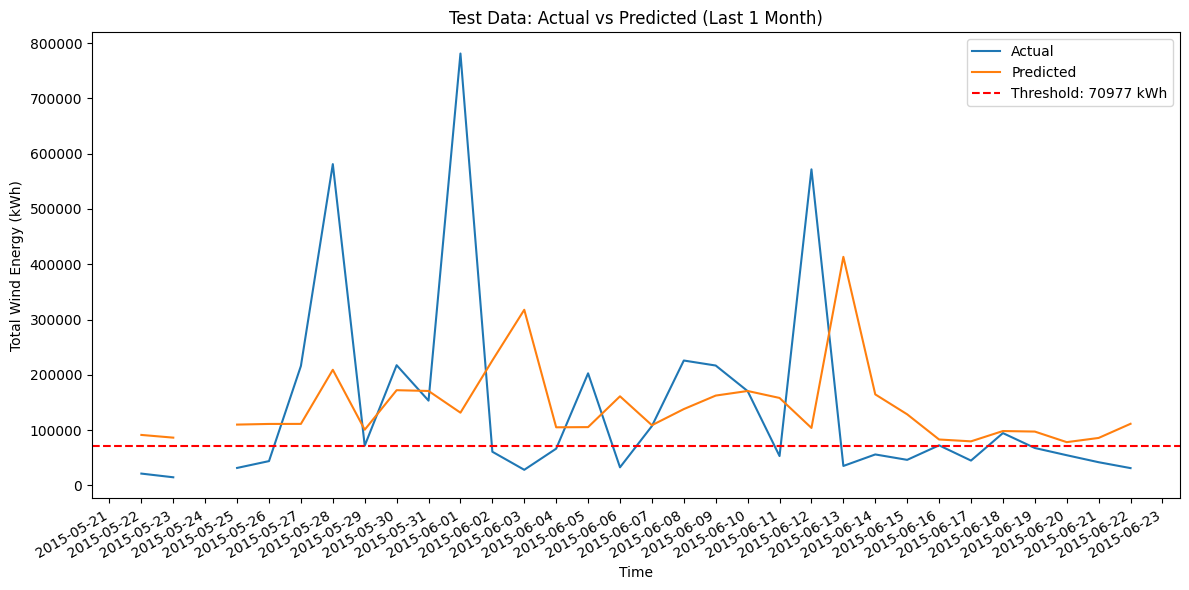

In [19]:
# Plot actual vs predicted for the last month of test data
plt.figure(figsize=(12, 6))

# Smooth out the data
y_true_smooth = y_test.resample('D').mean()
y_pred_smooth = pd.Series(y_test_pred, index=y_test.index).resample('D').mean()

# Filter to show only the last 1 month of data
last_month_start = y_true_smooth.index.max() - pd.DateOffset(months=1)
y_true_smooth_last_month = y_true_smooth[last_month_start:]
y_pred_smooth_last_month = y_pred_smooth[last_month_start:]

plt.plot(y_true_smooth_last_month.index, y_true_smooth_last_month, label='Actual')
plt.plot(y_true_smooth_last_month.index, y_pred_smooth_last_month, label='Predicted')

# Add horizontal line for threshold
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {round(threshold)} kWh')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=False))
plt.gca().yaxis.get_major_formatter().set_useOffset(False)
plt.gca().yaxis.get_major_formatter().set_scientific(False)

plt.gcf().autofmt_xdate()

plt.xlabel('Time')
plt.ylabel('Total Wind Energy (kWh)')
plt.title('Test Data: Actual vs Predicted (Last 1 Month)')
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# Convert to binary classification based on the threshold
y_binary_train = (y_train >= threshold).astype(int)
y_binary_val = (y_val >= threshold).astype(int)
y_binary_test = (y_test >= threshold).astype(int)

# Train a classification model (using RandomForestClassifier as an example)
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_binary_train)

# Predict probabilities on the validation and test sets
y_val_probs = rf_classifier.predict_proba(X_val)[:, 1]
y_test_probs = rf_classifier.predict_proba(X_test)[:, 1]

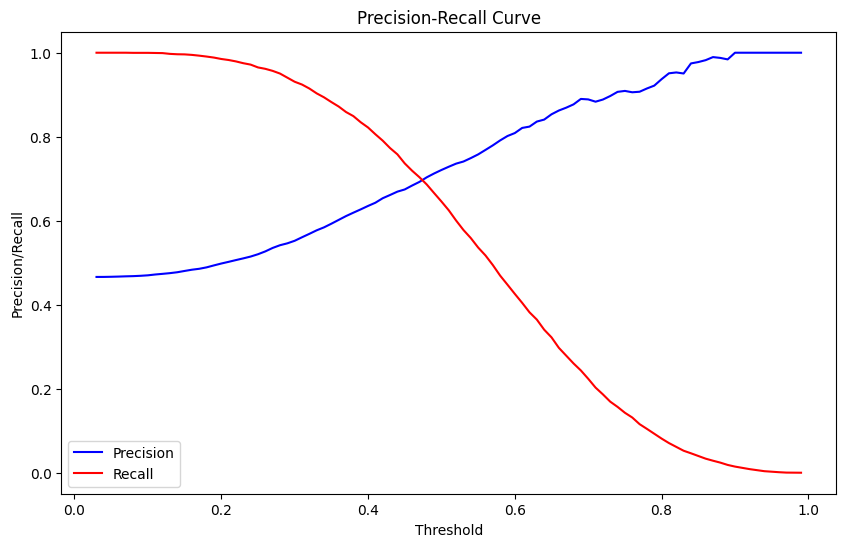

In [21]:
# Precision-Recall curve analysis
precision, recall, thresholds = precision_recall_curve(y_binary_val, y_val_probs)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], 'b-', label='Precision')
plt.plot(thresholds, recall[:-1], 'r-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [22]:
# Apply optimal threshold and evaluate
optimal_threshold = 0.86  # Example, select based on precision-recall tradeoff
y_test_pred_thresholded = (y_test_probs >= optimal_threshold).astype(int)
print(classification_report(y_binary_test, y_test_pred_thresholded))

              precision    recall  f1-score   support

           0       0.56      1.00      0.72      3885
           1       0.94      0.03      0.06      3164

    accuracy                           0.56      7049
   macro avg       0.75      0.52      0.39      7049
weighted avg       0.73      0.56      0.42      7049



In [23]:
# Analyze false positives
false_positives = (y_binary_test == 0) & (y_test_pred_thresholded == 1)
num_false_positives = false_positives.sum()
impact_of_false_positives = y_test[false_positives].sum()
print(f'Number of False Positives: {num_false_positives}')
print(f'Total energy incorrectly predicted as surplus: {impact_of_false_positives} kWh')

Number of False Positives: 7
Total energy incorrectly predicted as surplus: 353815.3832769506 kWh
